In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Patch

# Table of contents <a name="contents"></a>
1. [Loading Data](#LoadingData)
2. [HRStatus vs pcr](#HRstatus)
3. [Cluster by Composition](#cluster1)
4. [Single Variable Associations](#singlevar)

##  <a name="example"></a>

# Loading Data <a name="LoadingData"></a>

### notes

20 rows, 1 per patient

210 columns:

 - composition columns = 119 columns containing "_in_"
    - composition is the percent of that cell type in the specified compartment,
    - For example, 'HER2_in_Tum' is fraction HER2+ cells out of tumor cells and 
    'HER2_ER_in_Tum' is fraction HER2+/ER+ cells out of tumor cells.

- proximity columns = 78 columns containing "_to_"
    - proximity is the mean of log2(number of neighbors per cell)
    - For example, 'tumor_to_Lum_HER2' is the mean number of Luminal HER2+ tumor neighbors per tumor cell
    - 'immune_to_CD8Tcell' is the mean number of CD8 Tcell neighbors per immune cell
    - counts are in a 75 um radius, and log2 transformed

- entropy columns containing "_entropy_" (12 columns)
    - mean entropy in bits of each patient
    - For example, 'HRStatus_entropy' is the entropy of cell types that define HR status:
        ER, HER2, ER_HER2 and TN 
    - 'ImmuneType_entropy' is the entropy of immune cells: CD8, CD8, CD20 and CD68.

- pCR_RCB column:
    0 = responder, RCB of 1 or 0
    1 = nonresponder, RCB of 2 or more

[contents](#contents)


In [4]:
#set location of files (download data and then specify location)
rootdir = r'/mnt/c/Users/engje/Documents/Data/2020/20200706_NP001-36'
# go to location of files
os.chdir(rootdir)
os.listdir()

['20200514_NP001-36',
 '20200706_SpatialPlots',
 '20200708',
 '20200708_SpatialPlots',
 '20200709',
 '20200709_data_new',
 '20200709_SpatialPlots',
 '20200710',
 '20200710_oldseg',
 '20200810',
 '20200914',
 '20200914_data_new',
 '20200915',
 '20201012',
 '20201012_data',
 '20201013_NP001-36_napari.py',
 '20201021',
 '20201022',
 '20201023',
 '20201023b',
 '20201023_NP001-36_20um_NeighborhoodCounts.csv',
 '20201023_NP001-36_75um_NeighborhoodCounts.csv',
 '20201023_NP001-36_edge31_GatedPositiveCellNames.csv',
 '20201023_NP001-36_ManualPositive.csv',
 '20201023_NP001-36_ManualPositive_edge31.csv',
 '20201024',
 '20201024_NP001-036_annotation.csv',
 '20201024_NP036_edge308_CentroidXY.csv',
 '20201024_NP036_edge31_CentroidXY.csv',
 '20201024_NP036_edge62_CentroidXY.csv',
 '20201024_outcome_annotation.csv',
 '20201025s',
 '20201026',
 '20201026_Composition_to_pCR.csv',
 '20201026_l',
 '20201030',
 '20201030_Composition_to_pCR.csv',
 '20201030_l',
 '20201102',
 '20201102_CycIF_TDM1.csv',
 'c

In [6]:
os.chdir('HER2_heterogeneity_2021/cycIF')

In [14]:
#load positive data
s_pos_name = 'NP001-36_edge31'#'NP001-36_HER2B-TMAs'

s_date = '20201102'
#os.mkdir(s_date)
df_data = pd.read_csv(f'./20201102_CycIF_TDM1.csv',index_col=0)  
#s_date_data = '20201023'
#df_gate = pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv',index_col=0)

df_gate = pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_1.csv',index_col=0).append(pd.read_csv(f'./{s_date_data}_{s_pos_name}_GatedPositiveCellNames_2.csv',index_col=0))
print(f'Loaded {s_date_data}_{s_pos_name}_GatedPositiveCellNames.csv')
df_gate['Sample'] = [item.split('_')[0] for item in df_gate.index]
df_gate['countme'] = True
print(len(df_gate))

Loaded 20201023_NP001-36_edge31_GatedPositiveCellNames.csv
1001535


In [8]:
df_data['pCR'] = df_data.pCR_RCB.replace({1.0:'no pCR',0.0:'pCR'})

In [9]:
# color of Pcr
s_pcr = 'pCR'
lut_pcr = dict(zip(['pCR','no pCR'],cm.tab10.colors))


## Associate HR status with pcr <a name="HRstatus"></a>

I tested the association of the HRstatus clusters and found them significantly associated with response. I haven't tested other clusters yet, but by eye they don't look like they associate.

[contents](#contents)

0.021828732412072536


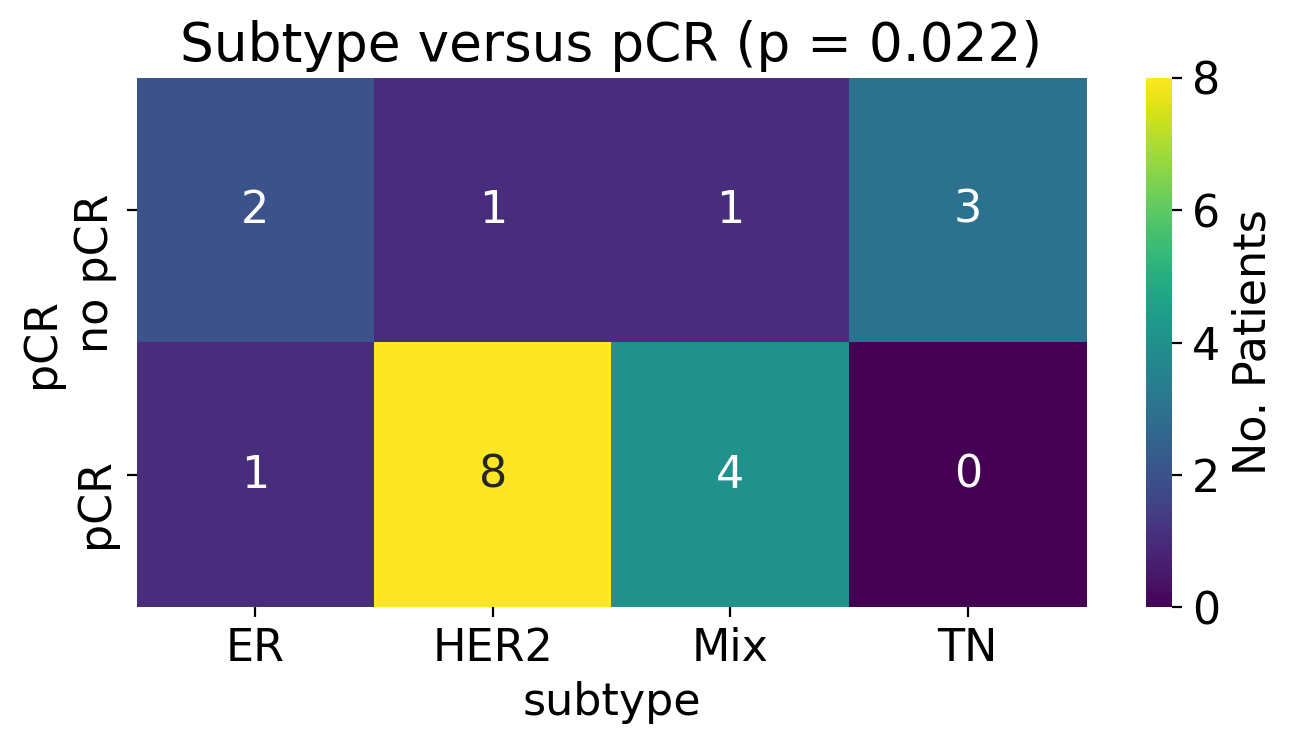

In [10]:
# test significanceof HR status clusters
def chi_heatmap(confusion_matrix,pvalue):
    fig,ax = plt.subplots(dpi=200,figsize=(7,4))
    sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'},cmap='viridis')
    ax.set_title(f"Subtype versus pCR (p = {pvalue:.3f})")
    plt.tight_layout()
    return(fig)
mpl.rcParams.update({'font.size': 16})
# 3 groups, Significant variables
g1 = [20, 7, 18]
g2 =  [10, 3, 4]
g3 = [2, 8, 16, 9, 12, 15, 19, 6, 11]
g4 = [13, 1, 5, 14,17]
df_group3 = pd.DataFrame(df_data.loc[:,'pCR'])
df_group3.loc[g1,'subtype'] = 'ER'
df_group3.loc[g2,'subtype'] = 'TN'
df_group3.loc[g3,'subtype'] = 'HER2'
df_group3.loc[g4,'subtype'] = 'Mix'
df_group3['countme'] = True
#chi squared 
confusion_matrix = pd.crosstab(df_group3.pCR, df_group3.subtype,df_group3.countme,aggfunc='count')
confusion_matrix = confusion_matrix.fillna(0)
chi2, pvalue, __, __  = stats.chi2_contingency(confusion_matrix)
print(pvalue)
fig = chi_heatmap(confusion_matrix,pvalue)
#fig.savefig(f'./{s_date}/Chi_square_HRStatus_clustering.pdf')
lut_hr = dict(zip(['TN','Mix','ER','HER2'],cm.tab10.colors))

# Cluster by cyclic IF cell type, color by pcr <a name="cluster1"></a>

For data exploration, I started by clustering the samples by different celltype groups defined by cyclic IF.

I tested the association of the HRstatus clusters and found them significantly associated with response. I haven't tested other clusters yet, but by eye they don't look like they associate.

[contents](#contents)

HRStatus
Int64Index([20, 7, 18, 10, 3, 4, 2, 8, 16, 9, 12, 15, 19, 6, 11, 13, 1, 5, 14,
            17],
           dtype='int64', name='CASE NUMBER')


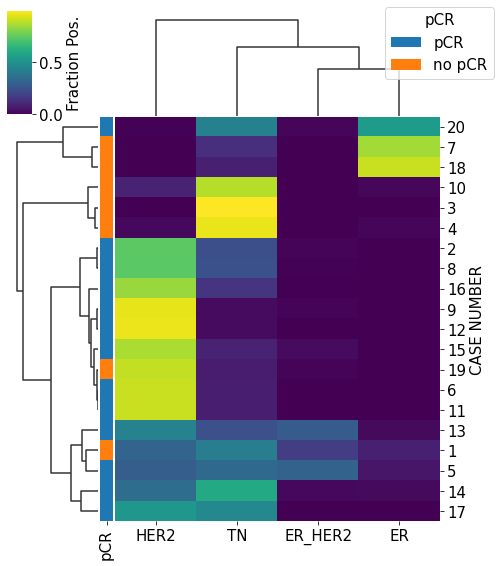

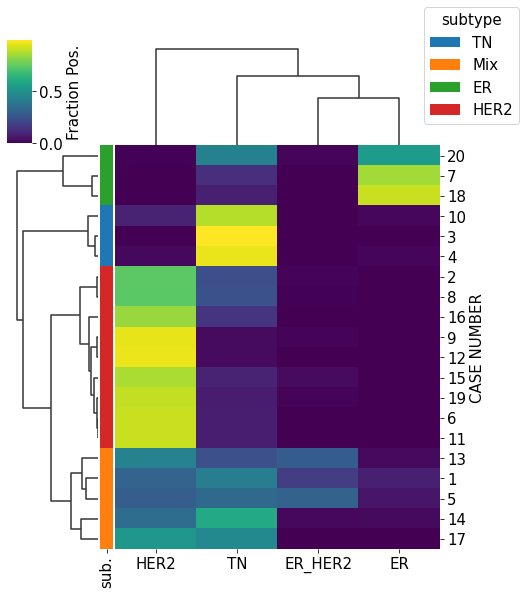

In [11]:
#heatmaps - color by pCR
#figure parameters
tu_heatmap = (7,8)
mpl.rcParams.update({'font.size': 15})
d_fraction = {'HRStatus':'Tum', 'celltype':'Tissue', 'proliferation':'Tissue',
              'CellProlif':'Tissue', 'ImmuneType':'Immune', 'Tcell_Immune':'Tcell',
              'StromalType':'Stroma','ImmuneFunc':'Tcell-Mac', 'NonTumor':'NonTum',
              'DiffState':'Tum', 'DiffStateHRStatus':'Tum','FinalCell':'Tissue'}
ls_cell = ['HRStatus','celltype','proliferation','CellProlif','ImmuneType','Tcell_Immune',
           'StromalType','ImmuneFunc','NonTumor','DiffState','DiffStateHRStatus','FinalCell']
for idx,s_cell in enumerate(ls_cell):
    print(s_cell)
    ls_cells = sorted(df_gate.loc[:,s_cell].dropna().unique() + f'_in_{d_fraction[s_cell]}')
    df_prop = df_data.loc[:,ls_cells + ['pCR']]
    species = df_prop.pop("pCR")
    row_colors = species.map(lut_pcr)
    #clustermap plot 
    df_plot = df_prop.fillna(0)
    df_plot.columns = [item.split('_in_')[0] for item in df_plot.columns]
    g = sns.clustermap(df_plot,figsize=tu_heatmap,cmap='viridis',row_colors=row_colors,cbar_kws={'label':'Fraction Pos.','format':'%.1f'},tree_kws=dict(linewidths=1.5))
    handles = [Patch(facecolor=lut_pcr[name]) for name in lut_pcr]
    plt.legend(handles, lut_pcr, title=s_pcr,
           bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    if s_cell == 'HRStatus':
        print(df_plot.index[g.dendrogram_row.reordered_ind])
    #g.savefig(f'./{s_date}/{s_pos_name}_{s_cell}_heatmap_pcr.pdf',dpi=150)
    if s_cell == 'HRStatus':
        df_prop['sub.'] = df_group3.subtype
        species = df_prop.pop("sub.")
        row_colors = species.map(lut_hr)
        g = sns.clustermap(df_plot,figsize=tu_heatmap,cmap='viridis',row_colors=row_colors,cbar_kws={'label':'Fraction Pos.','format':'%.1f'},tree_kws=dict(linewidths=1.5))
        handles = [Patch(facecolor=lut_hr[name]) for name in lut_hr]
        plt.legend(handles, lut_hr, title='subtype',
           bbox_to_anchor=(1.05, 1.05), bbox_transform=plt.gcf().transFigure, loc='upper right')
        #g.savefig(f'./{s_date}/{s_pos_name}_{s_cell}_heatmap_subtype.pdf',dpi=150)
    break


## Single Variable Association with pCR <a name="singlevar"></a>

Each of the celltypes were tested for single variable association with response. If a variable had a significant (p < 0.05) assosiation with response, it was used for clustering, below.

[contents](#contents)

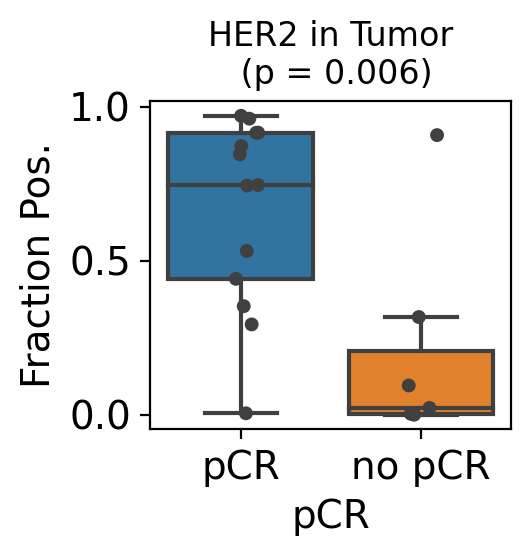

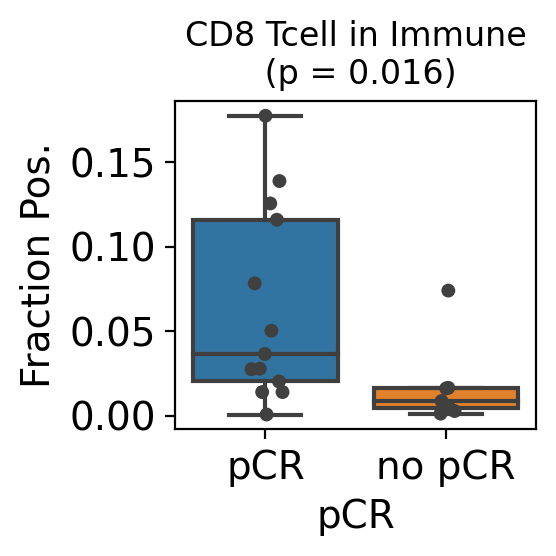

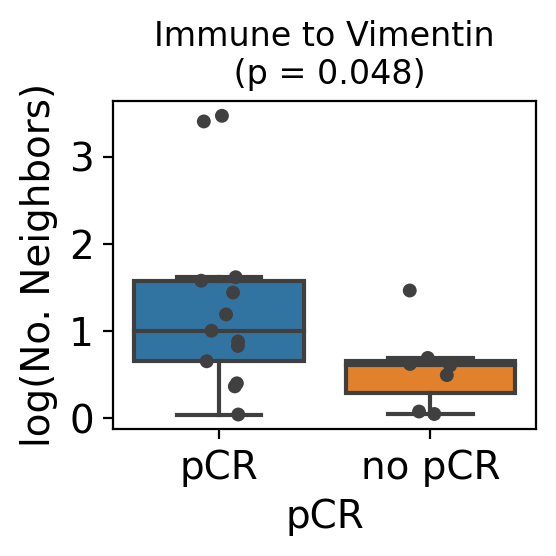

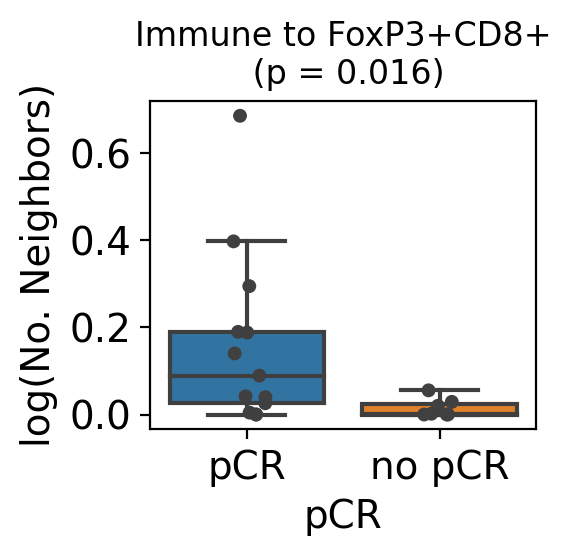

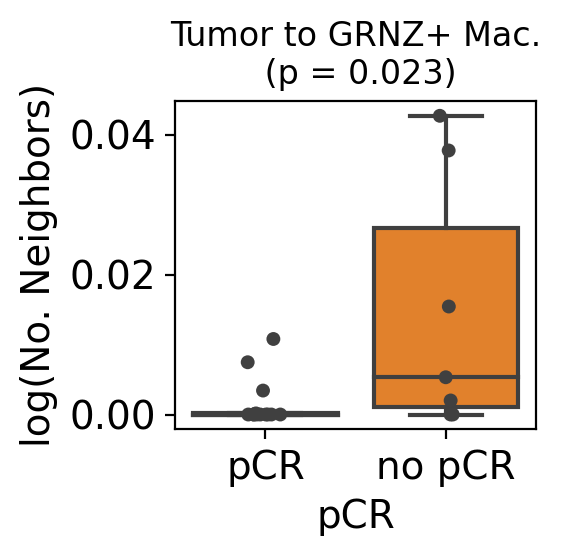

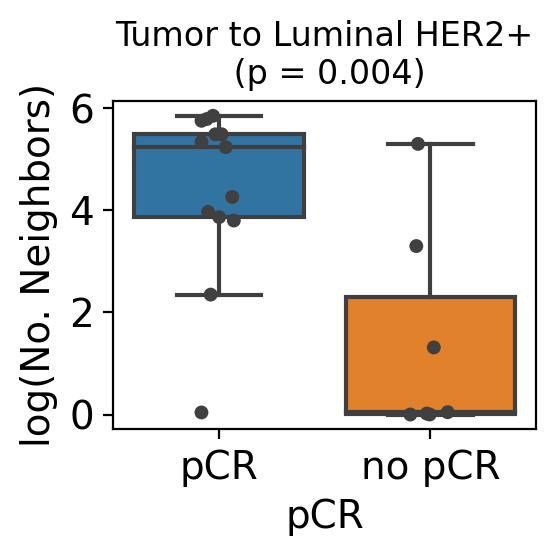

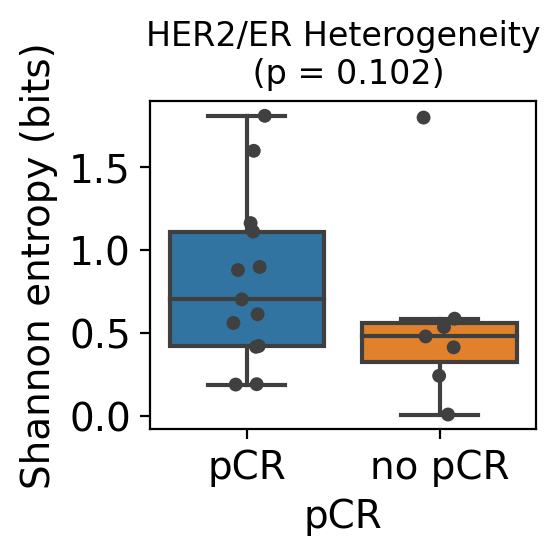

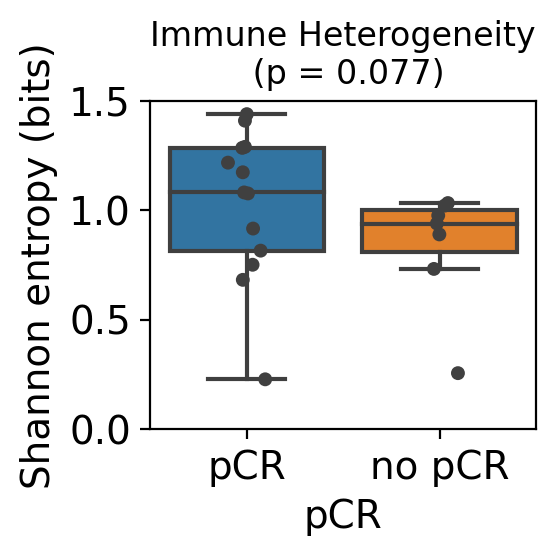

In [12]:
#plot single variable association
mpl.rcParams.update({'font.size': 14})
ls_sig = []
ls_pos = []
d_label = {'HER2_in_Tum':('Fraction Pos.','HER2 in Tumor'),'CD8Tcell_in_Immune':('Fraction Pos.','CD8 Tcell in Immune'),'immune_to_stromal_Vim':('log(No. Neighbors)','Immune to Vimentin'),
            'immune_to_CD8Tcell_FoxP3':('log(No. Neighbors)','Immune to FoxP3+CD8+'),'tumor_to_MyeloidImmune_GRNZB':('log(No. Neighbors)','Tumor to GRNZ+ Mac.'),
          'tumor_to_Lum_HER2':('log(No. Neighbors)','Tumor to Luminal HER2+'),'HRStatus_entropy':('Shannon entropy (bits)','HER2/ER Heterogeneity'),
          'ImmuneType_entropy':('Shannon entropy (bits)','Immune Heterogeneity'),}
for s_var, s_title in d_label.items():
    #print(s_var)
    statistic, pvalue = stats.mannwhitneyu(df_data.loc[df_data.groupby(s_pcr).groups['no pCR'],s_var],df_data.loc[df_data.groupby(s_pcr).groups['pCR'],s_var])
    fig,ax = plt.subplots(dpi=200,figsize=(3,3))
    sns.boxplot(y=s_var,x=s_pcr,data=df_data,order=['pCR','no pCR'],ax=ax,showfliers=False)
    sns.stripplot(y=s_var,x=s_pcr,data=df_data,order=['pCR','no pCR'],ax=ax,color=".25")
    ax.set_ylabel(s_title[0])
    if s_var == 'ImmuneType_entropy':
        ax.set_ylim(0,1.5)
    ax.set_title(f'{s_title[1]}\n (p = {pvalue:.3f})',fontsize=12,horizontalalignment='center')
    plt.tight_layout()
    #fig.savefig(f'./{s_date}/MannWhitneyU_{s_var}.pdf')
